# Huiswerkopdracht - Boekclassificatie

### Notebook van Esmee Kraan

**Disclaimer**: Stukken code in dit notebook zijn geschreven met ChatGPT, boven deze code staat dit vermeld met de context en wat voor prompt is gebruikt.

---

## Table of contents

1. [Introduction](#Introduction)

2. [The problem domain](#The-problem-domain)

4. [Business Understanding](#Business-Understanding)

5. [Required libraries](#Required-libraries)

6. [Data Understanding](#Data-Understanding)

7. [Data Prepartion](#Data-Preparation)

8. [Modeling](#Modeling)

9. [Evaluation](#Evaluation)

10. [Reproducibility](#Reproducibility)

---

# Introduction

[[ go back to the top ]](#Table-of-contents)

In deze huiswerkopdracht ga ik verder met de technieken die ik heb geleerd tijdens de werkcolleges. We hebben ons toen gericht op sentimentanalyse van IMDB-reviews, en nu ga ik aan de slag met boekteksten van Project Gutenberg. Dit is een online archief met meer dan 60.000 gratis boeken, wat supertof is! Het doel van deze opdracht is om een neuraal netwerk te bouwen dat kan voorspellen in welk genre een boek zich bevindt, op basis van tekstuele samples van 600 woorden. Dit is een geweldige kans om machine learning toe te passen op een nieuwe dataset en meer te leren over tekstclassificatie.

---


# The problem domain

[[ go back to the top ]](#Table-of-contents)

Boeken indelen in verschillende genres is echt belangrijk binnen de literatuur- en informatiekunde. Het maakt het voor lezers veel makkelijker om boeken te vinden die bij hun interesses passen. In dit project gebruik ik tekstuele samples van boeken van Project Gutenberg, die zijn opgedeeld in stukjes van 600 woorden. De genres zijn gecategoriseerd volgens de Library of Congress Classificatie.

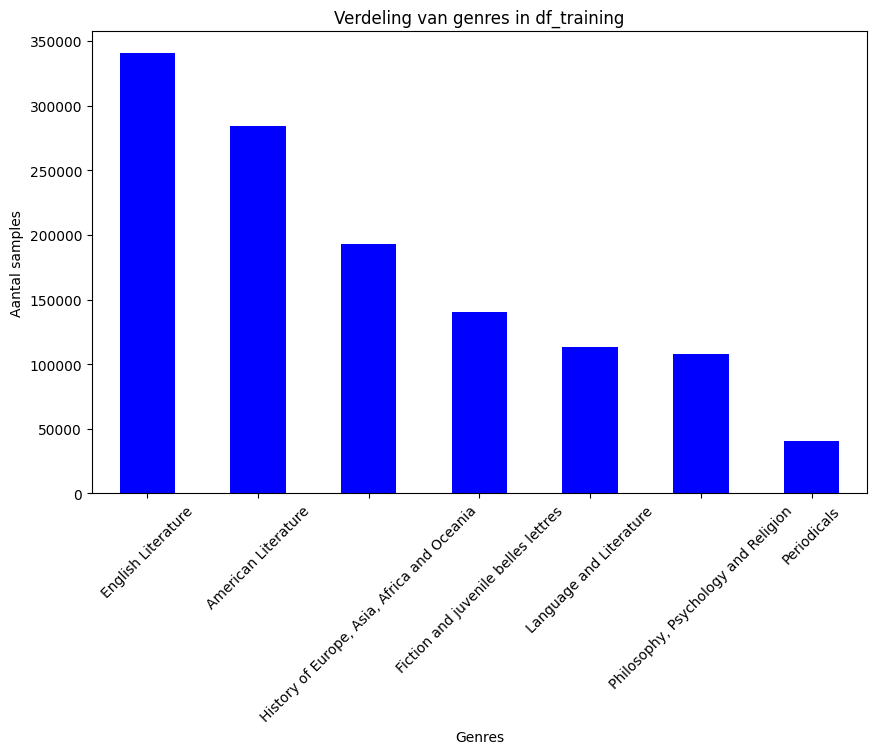

Met meer dan 1,59 miljoen records is het een flinke klus om te bekijken hoe goed mijn model kan voorspellen. Het is wel een uitdaging, vooral omdat de genres niet gelijk verdeeld zijn en er veel variatie is in schrijfstijlen en onderwerpen binnen elk genre.

---

# Business Understanding

[[ go back to the top ]](#Table-of-contents)

Het doel van deze opdracht is om een model te bouwen dat efficiënt en effectief het genre van een boek kan voorspellen aan de hand van de tekst. Dit is waardevol voor bibliotheken, boekwinkels en online platforms, omdat het aanbevelingen aan gebruikers verbetert en zo de klanttevredenheid en verkoop kan verhogen.

**Wat gaan we oplossen?**
> Ik wil een neuraal netwerk ontwikkelen dat het genre van een boek kan voorspellen op basis van de inhoud.

**KSF's van het project?**
> De Kritische Succesfactoren (KSF's) zijn onder andere de nauwkeurigheid van het model, de snelheid van classificatie, en de gebruiksvriendelijkheid van de applicatie. Het project is succesvol als het model met hoge nauwkeurigheid kan classificeren en makkelijk te integreren is in bestaande systemen.

**De context van de vraag van de klant?**  
> De klant vraagt om een systeem dat boeken kan classificeren. Dit helpt bij het verbeteren van aanbevelingssystemen, wat super belangrijk is voor klanttevredenheid en verkoop.

**Ontwerp of een Eindvisie**  
> Ik wil uiteindelijk een gebruiksvriendelijke interface creëren die mensen in staat stelt om boeken te classificeren en aanbevelingen te doen op basis van genres.

**Kan de vraag opgelost worden met de huidige data?**  
> De data is voldoende om een goed model te trainen, maar ik moet wel rekening houden met de ongelijke verdeling van de genres en de verschillende schrijfstijlen.

# Vereiste Bibliotheken

[[ ga terug naar de bovenkant ]](#Inhoudsopgave)

*Hier is een korte uitleg over de packages die ik gebruik om dit project werkend te krijgen. Dit is een voorbeeld van een random notebook online:*

Als je Python nog niet op je computer hebt staan, kun je de [Anaconda Python-distributie](http://continuum.io/downloads) gebruiken om de meeste benodigde Python-packages te installeren. Anaconda biedt een eenvoudige installer die je met een dubbelklik kunt gebruiken.

Dit notebook maakt gebruik van verschillende Python-packages die standaard worden meegeleverd met de Anaconda Python-distributie. De belangrijkste bibliotheken die ik zal gebruiken zijn:

* **NumPy**: Biedt een snelle numerieke array-structuur en hulpfuncties.
* **pandas**: Biedt een DataFrame-structuur om gegevens in het geheugen op te slaan en er gemakkelijk en efficiënt mee te werken.
* **scikit-learn**: Het essentiële machine learning-pakket in Python.
* **matplotlib**: Een basis plotbibliotheek in Python; de meeste andere Python-plotbibliotheken zijn hierop gebouwd.
* **Seaborn**: Een geavanceerde bibliotheek voor statistische visualisaties.
* **sounddevice**: Een bibliotheek voor het verwerken en beheren van audiogegevens (indien relevant voor het project).
* **tqdm**: Een bibliotheek voor het maken van voortgangsbalken in loops.

Om ervoor te zorgen dat je alle benodigde packages hebt, kun je ze installeren met `conda` of `pip`:

```bash
conda install numpy pandas scikit-learn matplotlib seaborn tqdm
pip install numpy pandas scikit-learn matplotlib seaborn tqdm
```

In [64]:
# Data Manipulation and Analysis
import pandas as pd  # type: ignore
import numpy as np  # type: ignore

# Machine Learning and Data Preprocessing
from sklearn.preprocessing import LabelEncoder  # type: ignore
from sklearn.model_selection import train_test_split  # type: ignore

# Visualization
import matplotlib.pyplot as plt  # type: ignore
import seaborn as sns  # type: ignore

# System and File Management
import sys
import os
import time

# AI packages
import tensorflow as tf  # type: ignore
from tensorflow import keras  # type: ignore
from tensorflow.keras import layers  # type: ignore
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder

# Progress Bar
from tqdm import tqdm  # type: ignore

# Tokenizer en Padding libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [65]:
df_val = pd.read_csv('dataset/validation.csv.gz')
df_test = pd.read_csv('dataset/testing.csv.gz')
df_training = pd.read_csv('dataset/training.csv.gz')

# Data Understanding

[[ go back to the top ]](#Table-of-contents)

---

In [66]:
print(df_training.head())
print(df_val.head())
print(df_test.head())

   usage           main genre  \
0  train  American Literature   
1  train  American Literature   
2  train  American Literature   
3  train  American Literature   
4  train  American Literature   

                                               title  samplenumber  \
0  The Works of John Greenleaf Whittier, Volume V...           600   
1  The Works of John Greenleaf Whittier, Volume V...          1200   
2  The Works of John Greenleaf Whittier, Volume V...          1800   
3  The Works of John Greenleaf Whittier, Volume V...          2400   
4  The Works of John Greenleaf Whittier, Volume V...          3000   

                                                 txt  
0  journey more terrible than that of the ideal p...  
1  great struggle for freedom but a soldier of th...  
2  says overrun with superstition on one occasion...  
3  practice of swearing although previously he te...  
4  all manner of uncleanness he would laugh at al...  
        usage           main genre  \
0  validatio

Op t eerste zicht zie ik geen ontbrekende of verkeerde waarde, de datasetes zijn vrij duidelijk ingedeeld met hun usage er zelfs bij vermeld. Maar ik weet nog niet zeker of de dataset schoon is daarom ga ik verder kijken.

In [67]:
print(df_training.info())
print(df_val.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220126 entries, 0 to 1220125
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   usage         1220126 non-null  object
 1   main genre    1220126 non-null  object
 2   title         1220126 non-null  object
 3   samplenumber  1220126 non-null  int64 
 4   txt           1220126 non-null  object
dtypes: int64(1), object(4)
memory usage: 46.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338103 entries, 0 to 338102
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   usage         338103 non-null  object
 1   main genre    338103 non-null  object
 2   title         338103 non-null  object
 3   samplenumber  338103 non-null  int64 
 4   txt           338103 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187969 

In [68]:
df_train = df_training.astype({"txt":"string"})
df_test = df_test.astype({"txt":"string"})
df_val = df_val.astype({"txt":"string"})

Ik zie ook dat elke dataset een `usage` kolom heeft waarin staat of het bedoelt is voor train, test of validatie. Ik wil voor elke df kijken of deze waarde uniek is en er geen andere waarden in zitten.

In [69]:
print(df_training['usage'].unique())
print(df_val['usage'].unique())
print(df_test['usage'].unique())

['train']
['validation']
['test']


ook wil ik in de kolom `main genre` kijken hoe de verdeling van de genres eruitziet, een ongelijke verdeling kan invloed hebben op de prestaties van het model.

In [70]:
print(df_training['main genre'].unique())
print(df_val['main genre'].unique())
print(df_test['main genre'].unique())

['American Literature' 'Fiction and juvenile belles lettres' 'Periodicals'
 'English Literature' 'Philosophy, Psychology and Religion'
 'History of Europe, Asia, Africa and Oceania' 'Language and Literature']
['American Literature' 'Philosophy, Psychology and Religion'
 'History of Europe, Asia, Africa and Oceania' 'English Literature'
 'Fiction and juvenile belles lettres' 'Periodicals'
 'Language and Literature']
['English Literature' 'American Literature' 'Periodicals'
 'Philosophy, Psychology and Religion'
 'Fiction and juvenile belles lettres' 'Language and Literature'
 'History of Europe, Asia, Africa and Oceania']


Verdeling van genres in df_training:
main genre
English Literature                             340450
American Literature                            284157
History of Europe, Asia, Africa and Oceania    193217
Fiction and juvenile belles lettres            140594
Language and Literature                        113459
Philosophy, Psychology and Religion            107821
Periodicals                                     40428
Name: count, dtype: int64


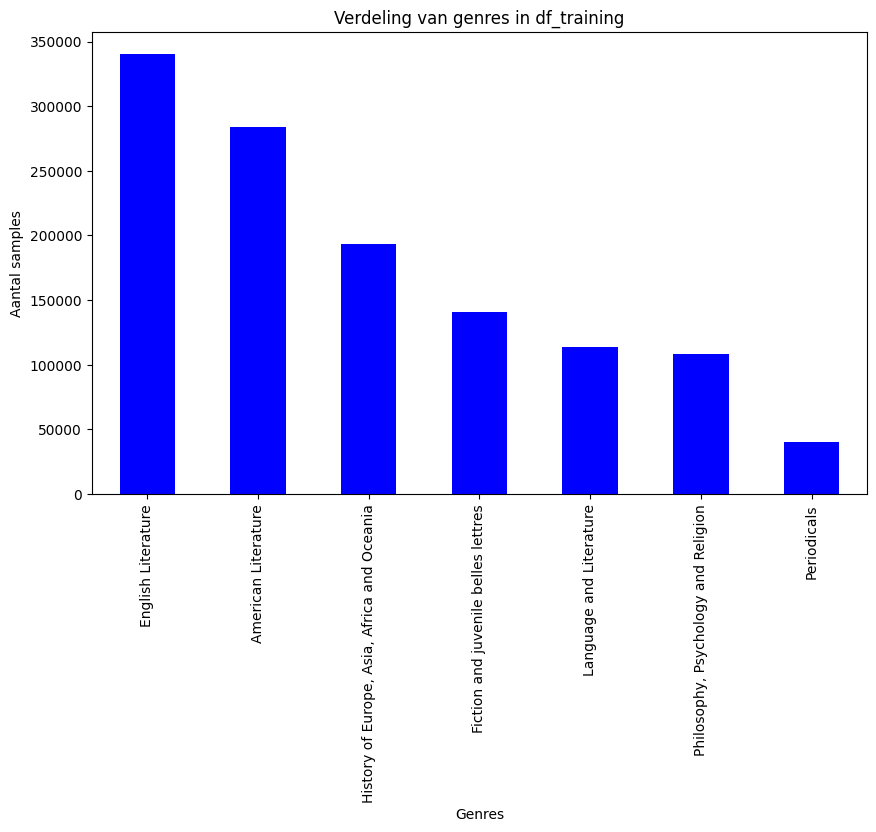

Verdeling van genres in df_val:
main genre
English Literature                             95271
American Literature                            77837
History of Europe, Asia, Africa and Oceania    56577
Fiction and juvenile belles lettres            42770
Language and Literature                        27030
Philosophy, Psychology and Religion            26197
Periodicals                                    12421
Name: count, dtype: int64


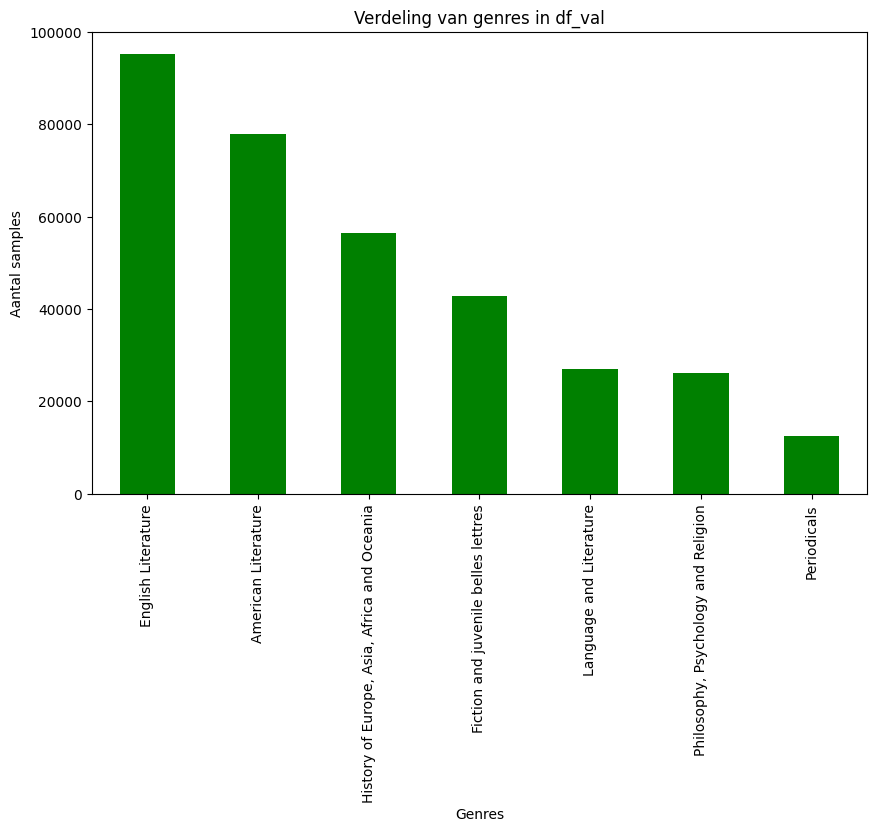

Verdeling van genres in df_test:
main genre
English Literature                             53054
American Literature                            44900
History of Europe, Asia, Africa and Oceania    30921
Fiction and juvenile belles lettres            20782
Language and Literature                        17527
Philosophy, Psychology and Religion            14914
Periodicals                                     5871
Name: count, dtype: int64


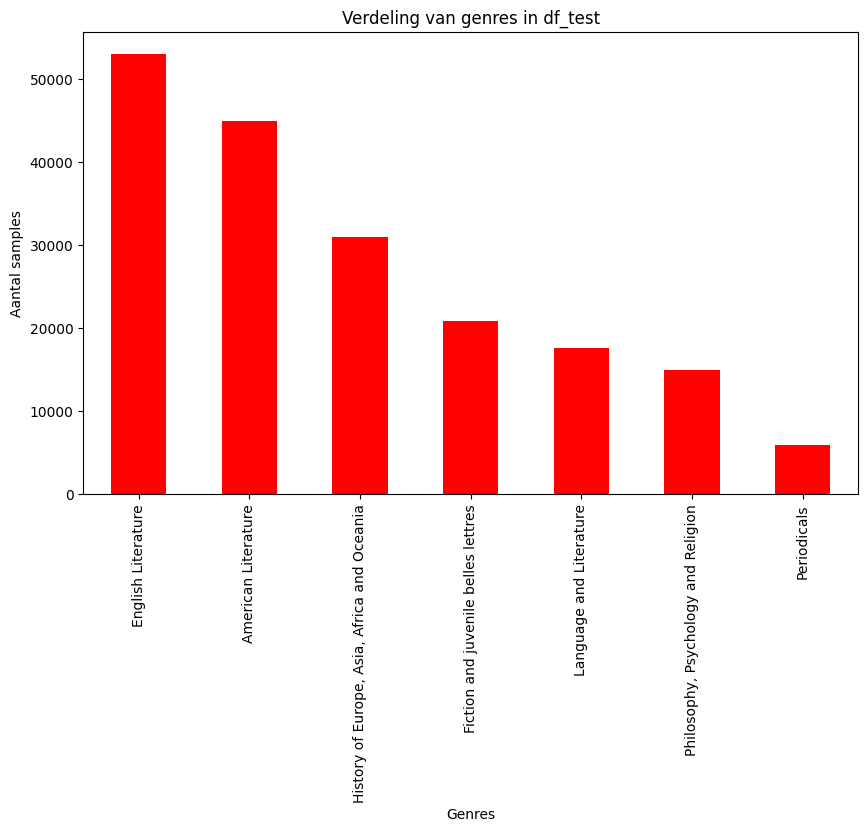

In [71]:
# df_training
print("Verdeling van genres in df_training:")
print(df_training['main genre'].value_counts())

plt.figure(figsize=(10, 6))
df_training['main genre'].value_counts().plot(kind='bar', color='blue')
plt.title('Verdeling van genres in df_training')
plt.xlabel('Genres')
plt.ylabel('Aantal samples')
plt.xticks(rotation=90)
plt.show()

# df_val
print("Verdeling van genres in df_val:")
print(df_val['main genre'].value_counts())

plt.figure(figsize=(10, 6))
df_val['main genre'].value_counts().plot(kind='bar', color='green')
plt.title('Verdeling van genres in df_val')
plt.xlabel('Genres')
plt.ylabel('Aantal samples')
plt.xticks(rotation=90)
plt.show()

# df_test
print("Verdeling van genres in df_test:")
print(df_test['main genre'].value_counts())

plt.figure(figsize=(10, 6))
df_test['main genre'].value_counts().plot(kind='bar', color='red')
plt.title('Verdeling van genres in df_test')
plt.xlabel('Genres')
plt.ylabel('Aantal samples')
plt.xticks(rotation=90)
plt.show()


De verhoudingen tussen genres blijven grotendeels gelijk over de drie datasets, wat goed is voor de representativiteit. In alle datasets zijn de genres in ongeveer dezelfde volgorde van frequentie:

- English Literature is het grootste genre, gevolgd door American Literature en History of Europe, Asia, Africa and Oceania.
- Het kleinste genre is in alle gevallen Periodicals.

Het lijkt erop dat de verdeling al op een consistente manier is gedaan, daarom ga ik er verder niks aan aanpassen.

Dan de kolom `txt` dit is de belangrijkste kolom omdat hier de teksten van elke sample in staan. Daarom ga ik deze kolom ook nog verkennen.

In [72]:
df_training['txt_length'] = df_training['txt'].apply(lambda x: len(x.split()))
df_val['txt_length'] = df_val['txt'].apply(lambda x: len(x.split()))
df_test['txt_length'] = df_test['txt'].apply(lambda x: len(x.split()))
print(df_training['txt_length'].describe())

count    1.220126e+06
mean     5.996347e+02
std      1.416758e+01
min      1.000000e+00
25%      6.000000e+02
50%      6.000000e+02
75%      6.000000e+02
max      6.000000e+02
Name: txt_length, dtype: float64


Ik pak hier voor elke kolom in `txt` de lengte van de tekst. Dit gebeurt door eerst de tekst te splitten op spaties met `x.split()` dit levert een lijst van woorden waarvan ik de lengte pak met `len()`. Het resultaat hiervan is het aan tal woorden in de tekst die wordt opgeslagen in een nieuwe kolom `txt_length` die ik hieronder kan plotten.

Het valt me gelijk op dat de `mean` niet 600 is, dit betekent dat niet elk stuk tekst 600 lang is. Hier moet ik rekening mee houden later en padding aan toevoegen.

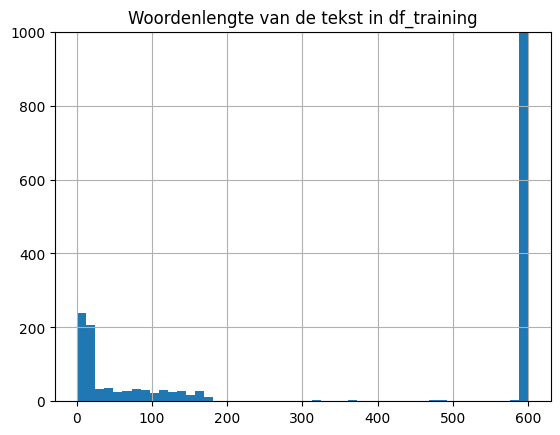

In [73]:
df_training['txt_length'].hist(bins=50)
plt.ylim(0, 1000)
plt.title('Woordenlengte van de tekst in df_training')
plt.show()

Op de plot lijkt alles op 600 te zitten maar uit de describe was al zeker te zien dat dit niet het geval was. Daarom toon ik nog voor de zekerheid de unieke waarden in elke dataset.

In [74]:
print(df_training['txt_length'].unique())

[600  11   4 158  38  12 157 161   1 107  30  94  63  24 349 126   6  43
   8 130  20 111 170 129 326  84 483 138   9  31  21  10 123 186  26   3
  14  17 137  47   5 132  16 155  23 122  13  46 135 103  48 121 124 145
  75  78  22  29  35  92  76 167 139 368  99  56  19  97  18  59 100  72
  55  52   2  54  74  15 159 108 134 146 141  88 115  82   7  69 175  60
 342  91 127  27 479 112  70 169 152 113  98  96  83 136  42 140 106  68
 162 153 420  73 156 591 330  79  93 188  41  45 148  34 173 142  37  86
  77  65 144 133  44  50 508 168  87  67  40 429  89 164 109  33  90 587
 119 110 457 125 150 165  80 172  25 315 149  49  64  62 176 371  61  81
 353 128 120 101  39 105  58 114  32 481  71 147  95  85  66 160 131 116
 324 166 118 171  57 289 117 379 438 586 204 318 498 492 338 259 227 394
 564 577 480 413 258 473 367 317 249 282]


In [75]:
df_training.describe()

,samplenumber,txt_length
count,1.220126e+06,1.220126e+06
mean,8.969360e+04,5.996347e+02
std,2.444388e+05,1.416758e+01
min,0.000000e+00,1.000000e+00
25%,1.800000e+04,6.000000e+02
50%,4.200000e+04,6.000000e+02
75%,8.100000e+04,6.000000e+02
max,4.410600e+06,6.000000e+02


In [76]:
print(df_val['txt_length'].unique())

[600 111   4  15  11   6  20 390  21 146  33   5 154 171  22 102   1  73
  23  14 135   2  25  16  84  10  60 164   8 118  74  17  27  19  44  30
   3  39 173 138  70  18 152 161 128 122  76  40 139 151 205  24   7 116
 107 123  58  47  43  13 126 169  12 100 117  50   9  79  61  69 153  91
  67  36  81  29  62 149  68  87 147  28 158 106  90  77 167  31 109  99
 131  86 270 145  65  98 163  49 168 542]


In [77]:
print(df_test['txt_length'].unique())

[600 103  11 251  43   7  23 196  19  80  10  36  78   5  20 238 127   1
  16 133 143   9   2  67  17  15 154  13  32  24  21 149 141 138 176   6
 115  52  48  26  63 140  37   4  71   8 166 152   3  30  91  70  39  22
  55 139 480 142 105  77  41  12  31  25  65 148 120  94  44  96 101 159
 130 153]


Niet elke lengte is dus 600, dit lossen we later op met padding.

Tot slot wil ik nog op ontbrekende waarden controleren voordat ik de data ga prepareren/ mankementen ga oplossen.

In [78]:
print(df_training.isnull().sum())
print(df_val.isnull().sum())
print(df_test.isnull().sum())

usage           0
main genre      0
title           0
samplenumber    0
txt             0
txt_length      0
dtype: int64
usage           0
main genre      0
title           0
samplenumber    0
txt             0
txt_length      0
dtype: int64
usage           0
main genre      0
title           0
samplenumber    0
txt             0
txt_length      0
dtype: int64


Dit is mooi, ik wil nog kijken op duplicates.

In [79]:
print(df_training.duplicated().sum())
print(df_val.duplicated().sum())
print(df_test.duplicated().sum())

110
0
0


Ik zie wat duplicate waarden in df_training waar ik naar wil kijken.

In [80]:
duplicates = df_training[df_training.duplicated(keep=False)]
duplicates.head(10)

,usage,main genre,title,samplenumber,txt,txt_length
77488,train,English Literature,All's Well That Ends Well,1800,practices he hath persecuted time with hope an...,600
77489,train,English Literature,All's Well That Ends Well,2400,so above me in his bright radiance and collate...,600
77491,train,English Literature,All's Well That Ends Well,3600,friend prejudicates the business and would see...,600
77492,train,English Literature,All's Well That Ends Well,4200,steward madam the care i have had to even your...,600
77493,train,English Literature,All's Well That Ends Well,4800,good theres yet one good in ten countess what ...,600
77494,train,English Literature,All's Well That Ends Well,5400,i am thy mother whats the matter that this dis...,600
77495,train,English Literature,All's Well That Ends Well,6600,that you will stay behind us parolles tis not ...,600
77496,train,English Literature,All's Well That Ends Well,7200,king thus he his special nothing ever prologue...,600
77497,train,English Literature,All's Well That Ends Well,7800,damp moist hesperus hath quenchd his sleepy la...,600
77498,train,English Literature,All's Well That Ends Well,8400,scolding quean to a wrangling knave as the nun...,600


Het lijkt erop dat de `txt` kolom geen duplicates bevat maar dat deze gemarkeerd worden als duplicate omdat de waarden in andere kolommen (zoals usage, main genre, en title) ook identiek zijn, kunnen ze als duplicaten worden beschouwd.

# Data Preparation

[[ go back to the top ]](#Table-of-contents)

Bij de data understanding heb ik ontdekt dat de lengte van `txt` in elke kolom niet 600 is. Daarom moeten we in ieder geval padding toevoegen zodat deze allemaal aangevuld worden naar 600 woorden. Ook moeten de woorden getokenized worden zodat ieder woord een eigen integer waarde krijgt.

---

De dataframes tokenizen en padden is vrij verwachtend van mijn desktop. Daarom heb ik een functie gemaakt waarmee ik subsets kan maken die wel de verhouding van genres aanhoudt in de oorspronkelijke dataset.

**Note:** Deze functie is geschreven met ChatGPT met de prompt "Maak een functie die een subset maakt van mijn dataframe maar die wel de verhouding van genres aanhoudt".

In [81]:
def create_stratified_subset(df, desired_size):
    # Bepaal de verhouding van elk genre
    genre_counts = df['main genre'].value_counts()

    # Bereken het percentage van elk genre
    genre_percentages = genre_counts / len(df)

    # Bepaal het aantal voor elke genre dat je wilt opnemen in de subset
    subset_counts = (genre_percentages * desired_size).round().astype(int)

    # Maak de subset aan met behoud van de genre verhouding
    subset = pd.concat([df[df['main genre'] == genre].sample(n=subset_counts[genre], random_state=42) for genre in subset_counts.index])

    return subset

# Maak subsets aan voor elke dataset met 10k rows
subset_training_10k = create_stratified_subset(df_training, 10000)
subset_val_10k = create_stratified_subset(df_val, 10000)
subset_test_10k = create_stratified_subset(df_test, 10000)

# Bekijk de nieuwe subsets
print("Subset Training Genre Verdeling:")
print(subset_training_10k['main genre'].value_counts())

print("\nSubset Validatie Genre Verdeling:")
print(subset_val_10k['main genre'].value_counts())

print("\nSubset Test Genre Verdeling:")
print(subset_test_10k['main genre'].value_counts())

Subset Training Genre Verdeling:
main genre
English Literature                             2790
American Literature                            2329
History of Europe, Asia, Africa and Oceania    1584
Fiction and juvenile belles lettres            1152
Language and Literature                         930
Philosophy, Psychology and Religion             884
Periodicals                                     331
Name: count, dtype: int64

Subset Validatie Genre Verdeling:
main genre
English Literature                             2818
American Literature                            2302
History of Europe, Asia, Africa and Oceania    1673
Fiction and juvenile belles lettres            1265
Language and Literature                         799
Philosophy, Psychology and Religion             775
Periodicals                                     367
Name: count, dtype: int64

Subset Test Genre Verdeling:
main genre
English Literature                             2822
American Literature                  

Daarna moeten we `main genre` omzetten naar een getal zodat deze ook in een model kan, dit doe ik met behulp van de `LabelEncoder()` functie van sklearn. Dit geeft een binaire matrix terug waarin welke kolom een genre vertegenwoordigt.`

In [82]:
# Functie om one-hot encoding toe te passen op de main genre kolom
subset_training_10k['genre_nr'] = LabelEncoder().fit_transform(subset_training_10k['main genre'])
subset_test_10k['genre_nr'] = LabelEncoder().fit_transform(subset_test_10k['main genre'])
subset_val_10k['genre_nr'] = LabelEncoder().fit_transform(subset_val_10k['main genre'])

Om te checken of de LabelEncoder goed is gegaan en voor elke genre een nummer is gezet bekijk ik eerst nogmaals alle genres die in elke dataset staan.

In [83]:
# Print de unieke genres per dataset
print(subset_training_10k['main genre'].unique())
print(subset_test_10k['main genre'].unique())
print(subset_val_10k['main genre'].unique())

['English Literature' 'American Literature'
 'History of Europe, Asia, Africa and Oceania'
 'Fiction and juvenile belles lettres' 'Language and Literature'
 'Philosophy, Psychology and Religion' 'Periodicals']
['English Literature' 'American Literature'
 'History of Europe, Asia, Africa and Oceania'
 'Fiction and juvenile belles lettres' 'Language and Literature'
 'Philosophy, Psychology and Religion' 'Periodicals']
['English Literature' 'American Literature'
 'History of Europe, Asia, Africa and Oceania'
 'Fiction and juvenile belles lettres' 'Language and Literature'
 'Philosophy, Psychology and Religion' 'Periodicals']


Nu ik weet hoeveel en welke genres er zijn wil ik van elke dataset een rij bekijken voor elke unieke waarde in de nieuwe kolom `genre_nr`. Daarom maak ik snel een subset zonder duplicates om alleen de eerste rij voor elke unieke waarde in `genre_nr` te zien. Dit doe ik voor elke dataframe.

In [84]:
# Bekijk een rij voor elke unieke waarde in 'genre_nr' in subset_training
unique_training_genres = subset_training_10k.drop_duplicates(subset='genre_nr')
print(unique_training_genres[['main genre', 'genre_nr']])

# Bekijk een rij voor elke unieke waarde in 'genre_nr' in subset_test_10k
unique_test_genres = subset_test_10k.drop_duplicates(subset='genre_nr')
print(unique_test_genres[['main genre', 'genre_nr']])

# Bekijk een rij voor elke unieke waarde in 'genre_nr' in subset_val_10k
unique_val_genres = subset_val_10k.drop_duplicates(subset='genre_nr')
print(unique_val_genres[['main genre', 'genre_nr']])

                                          main genre  genre_nr
278686                            English Literature         1
1214314                          American Literature         0
644871   History of Europe, Asia, Africa and Oceania         3
911042           Fiction and juvenile belles lettres         2
633989                       Language and Literature         4
41865            Philosophy, Psychology and Religion         6
542074                                   Periodicals         5
                                         main genre  genre_nr
140276                           English Literature         1
181201                          American Literature         0
16094   History of Europe, Asia, Africa and Oceania         3
12488           Fiction and juvenile belles lettres         2
7951                        Language and Literature         4
30637           Philosophy, Psychology and Religion         6
103603                                  Periodicals         5


Zo weet ik zeker dat elke genre er in zit en een uniek nummer heeft gekregen.

Ik heb ervoor gekozen om eerst 10.000 woorden te doen omdat dit ook zo ging bij het huiswerk en een padding van 600 omdat dit in de opdracht stond.

In [85]:
train_tokenized_10k = Tokenizer(num_words=10000)
train_tokenized_10k.fit_on_texts(subset_training_10k['txt'])
train_tokenized_10k.word_index

{'the': 1,
 'and': 2,
 'of': 3,
 'to': 4,
 'a': 5,
 'in': 6,
 'i': 7,
 'he': 8,
 'that': 9,
 'was': 10,
 'it': 11,
 'his': 12,
 'with': 13,
 'as': 14,
 'for': 15,
 'you': 16,
 'is': 17,
 'had': 18,
 'but': 19,
 'her': 20,
 'not': 21,
 'at': 22,
 'be': 23,
 'on': 24,
 'she': 25,
 'by': 26,
 'him': 27,
 'have': 28,
 'which': 29,
 'they': 30,
 'this': 31,
 'from': 32,
 'all': 33,
 'my': 34,
 'were': 35,
 'so': 36,
 'me': 37,
 'or': 38,
 'one': 39,
 'said': 40,
 'we': 41,
 'an': 42,
 'are': 43,
 'there': 44,
 'their': 45,
 'no': 46,
 'if': 47,
 'when': 48,
 'who': 49,
 'would': 50,
 'them': 51,
 'what': 52,
 'been': 53,
 'will': 54,
 'out': 55,
 'up': 56,
 'then': 57,
 'do': 58,
 'more': 59,
 'into': 60,
 'now': 61,
 'man': 62,
 'could': 63,
 'its': 64,
 'your': 65,
 'some': 66,
 'time': 67,
 'very': 68,
 'has': 69,
 'like': 70,
 'than': 71,
 'about': 72,
 'our': 73,
 'little': 74,
 'upon': 75,
 'did': 76,
 'well': 77,
 'only': 78,
 'see': 79,
 'any': 80,
 'other': 81,
 'after': 82,
 'befo

In [86]:
#vul de reviews aan tot 600 woorden
sequences_train_10k = train_tokenized_10k.texts_to_sequences(subset_training_10k['txt'])
padded_train_10k = pad_sequences(sequences_train_10k, maxlen=600)
padded_train_10k[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,   92, 5766,   57,   25,    2,    1, 2084, 1679,  122,   42,
       2768,  223,    1,  461,  235,   10,  140, 2613, 1610,    2,   44,
         35,   66, 5767,   26,    1,  347,    3,  210,   25,   63,   78,
         79,   27,   19,    6,   20,  113,  186,   14,   25,  334,   91,
         25, 1050,    9,    8,   18,   21,  125,  227,    4,  435,  134,
         14,   25, 1242,   86,   27,   25,  167,    5, 3724,   24,    1,
        155,   16,  475,   37,   40,    1,  961,  240,   16,   76, 4690,
         37,   16,    2,   19,    7,   10, 6913,   11,   10,  265,   36,
         25, 1588,   20,  612,    4,   12,  144,    2,   10,  314,   26,
          5, 1375, 3663,   32,    1,  559, 1206,   47,    7,   63,   28,
         53,   44,   25, 2033,   46,    7,  130, 4194,   16,   35,   21,
          2,    7,   97,   21,  126,    3,   11,   

In [87]:
test_tokenized_10k = Tokenizer(num_words=10000)
test_tokenized_10k.fit_on_texts(subset_test_10k['txt'])
test_tokenized_10k.word_index

{'the': 1,
 'and': 2,
 'of': 3,
 'to': 4,
 'a': 5,
 'in': 6,
 'he': 7,
 'i': 8,
 'that': 9,
 'was': 10,
 'it': 11,
 'his': 12,
 'with': 13,
 'for': 14,
 'as': 15,
 'you': 16,
 'had': 17,
 'is': 18,
 'her': 19,
 'but': 20,
 'not': 21,
 'at': 22,
 'be': 23,
 'she': 24,
 'on': 25,
 'him': 26,
 'by': 27,
 'have': 28,
 'they': 29,
 'this': 30,
 'which': 31,
 'from': 32,
 'all': 33,
 'my': 34,
 'were': 35,
 'so': 36,
 'me': 37,
 'one': 38,
 'we': 39,
 'said': 40,
 'or': 41,
 'no': 42,
 'there': 43,
 'their': 44,
 'an': 45,
 'are': 46,
 'who': 47,
 'if': 48,
 'when': 49,
 'would': 50,
 'them': 51,
 'what': 52,
 'been': 53,
 'will': 54,
 'up': 55,
 'out': 56,
 'then': 57,
 'more': 58,
 'do': 59,
 'now': 60,
 'could': 61,
 'into': 62,
 'your': 63,
 'its': 64,
 'man': 65,
 'some': 66,
 'time': 67,
 'very': 68,
 'like': 69,
 'than': 70,
 'has': 71,
 'little': 72,
 'about': 73,
 'upon': 74,
 'well': 75,
 'only': 76,
 'our': 77,
 'did': 78,
 'any': 79,
 'see': 80,
 'other': 81,
 'before': 82,
 'gre

In [88]:
#vul de reviews aan tot 600 woorden
sequences_test_10k = test_tokenized_10k.texts_to_sequences(subset_test_10k['txt'])
padded_test_10k = pad_sequences(sequences_test_10k, maxlen=600)
padded_test_10k[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,   16,   28,   88,    5,  877,    6, 1453,    2,
         28,  422,    5,   65,    3,  581,   43,   18,   42, 1023, 1262,
          4,   11,  168,   48,  446,    3,    1,  326,  146,    1,  326,
         18,  232, 6098, 1044,  220,  518,   11,   14,   30,  415,    1,
       1502,   34,  264,    7,   40,    4, 6099,  110, 6098,   54,  122,
          9,    8,   17,    5,  635,    6,   12,  965, 6099,  886,    2,
       1902,   16,  170,   24,  192,   29,   33,  661,  303,   75,   11,
         18,  856,    1, 1502, 1657,    4,   28,  664,    4,  775,   49,
         38,   18,  693,   25,    6,  113,    7,  538,   13,    5, 2267,
        102,  194,   39,   54,  122,   76,    3,  856, 1561,   30,  415,
         11,   54,   23,  232, 1258,  110, 6098,    4,  305,   16,  339,
          1, 1454,    8, 3835, 1004,   11, 6098,  3

In [89]:
val_tokenized_10k = Tokenizer(num_words=10000)
val_tokenized_10k.fit_on_texts(subset_val_10k['txt'])
val_tokenized_10k.word_index

{'the': 1,
 'and': 2,
 'of': 3,
 'to': 4,
 'a': 5,
 'in': 6,
 'i': 7,
 'that': 8,
 'he': 9,
 'was': 10,
 'it': 11,
 'his': 12,
 'with': 13,
 'for': 14,
 'as': 15,
 'you': 16,
 'is': 17,
 'had': 18,
 'her': 19,
 'but': 20,
 'not': 21,
 'at': 22,
 'on': 23,
 'be': 24,
 'she': 25,
 'by': 26,
 'have': 27,
 'him': 28,
 'they': 29,
 'which': 30,
 'this': 31,
 'from': 32,
 'all': 33,
 'my': 34,
 'were': 35,
 'so': 36,
 'me': 37,
 'we': 38,
 'one': 39,
 'said': 40,
 'an': 41,
 'or': 42,
 'their': 43,
 'are': 44,
 'there': 45,
 'no': 46,
 'if': 47,
 'when': 48,
 'who': 49,
 'would': 50,
 'them': 51,
 'been': 52,
 'what': 53,
 'will': 54,
 'out': 55,
 'up': 56,
 'then': 57,
 'do': 58,
 'more': 59,
 'could': 60,
 'now': 61,
 'into': 62,
 'its': 63,
 'man': 64,
 'your': 65,
 'some': 66,
 'very': 67,
 'has': 68,
 'time': 69,
 'like': 70,
 'our': 71,
 'little': 72,
 'about': 73,
 'than': 74,
 'upon': 75,
 'did': 76,
 'well': 77,
 'only': 78,
 'any': 79,
 'see': 80,
 'other': 81,
 'before': 82,
 'can

In [90]:
#vul de reviews aan tot 600 woorden
sequences_val_10k = val_tokenized_10k.texts_to_sequences(subset_val_10k['txt'])
padded_val_10k = pad_sequences(sequences_val_10k, maxlen=600)
padded_val_10k[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0, 4569,   53, 6845,   27,   16,    3,   31,    1, 3387,    3,
         88, 4774, 4428,   26,   16,    4,  967,   11, 4569,    7,  297,
         29,   27,   52, 1131,   26, 3840,    4,   11,   11,  990,   21,
         30,  111,    1,  381,  553,   55,  143, 4486,   14,   43, 1259,
         17,   82,   16, 4569,  374,   27,   46,  158,  374, 1170,   21,
       3840,   93,   38, 3266,   16,   46,    8,  177,  100,   24, 8902,
         22,    1,    6,    1,  364,   69,   38,   44,    6, 1084,  108,
       2416,    2,   38,   83,  126, 1133,    4,   24, 3767, 2490,   19,
          6,  205,  233, 1002, 2150,   45,   17,    5,  422,   14,   16,
        461,   30,   16,   54,   21,   70,    4, 48

Om genoeg data te hebben om te trainen laad ik ook de GLoVe dataset in.

Voordat we de modelling fase ingaan wil ik zeker weten dat alle datasets dezelfde lengte hebben.

In [91]:
print(padded_train_10k.shape)  # Dit zou (10000, 600) moeten zijn
print(subset_training_10k['genre_nr'].shape)  # Dit zou (10000,) moeten zijn
print(padded_val_10k.shape)  # Dit zou (9999, 600) moeten zijn
print(subset_val_10k['genre_nr'].shape)  # Dit zou (9999,) moeten zijn

(10000, 600)
(10000,)
(9999, 600)
(9999,)


# Modeling

[[ go back to the top ]](#Table-of-contents)

Voor de modellerings fase wil ik de modellen van beide werkcollege's toepassen. Ik loop voor elk model langs wat deze bevat en waarom.

---

<div class="alert alert-block alert-danger"><b>Waarschuwing:</b> Het runnen van deze modellen vereist veel van je systeem.</div>

### Model 0: Neuraal Netwerk met SimpleRNN Layer

In [174]:
# 0. SimpleRNN Model
model_0 = keras.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=7, input_length=600),
    keras.layers.SimpleRNN(32, return_sequences=False),
    keras.layers.Dense(7, activation='softmax')
])

model_0.build(input_shape=(None, 600))

model_0.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_35 (Embedding)        │ (None, 600, 7)         │        70,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 32)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,511 (279.34 KB)

 Trainable params: 71,511 (279.34 KB)

 Non-trainable params: 0 (0.00 B)

In [175]:
model_0.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_0 = model_0.fit(padded_train_10k, subset_training_10k['genre_nr'], epochs=3, validation_data=(padded_val_10k, subset_val_10k['genre_nr']))

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - accuracy: 0.2531 - loss: 1.8316 - val_accuracy: 0.2818 - val_loss: 1.7882
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 143ms/step - accuracy: 0.3063 - loss: 1.7506 - val_accuracy: 0.2663 - val_loss: 1.7741
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - accuracy: 0.4079 - loss: 1.5901 - val_accuracy: 0.2717 - val_loss: 1.8311


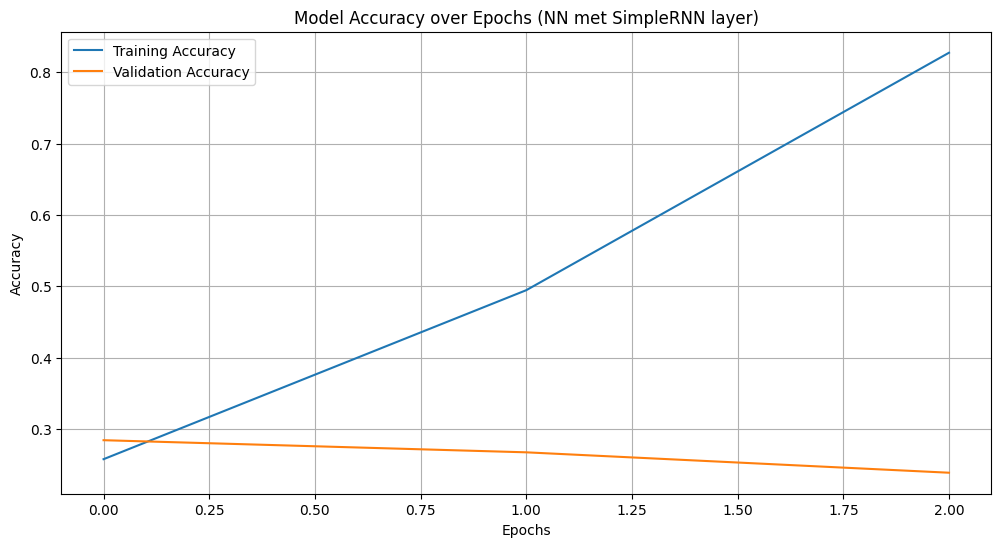

In [94]:
#plot de accuracy en validated accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_0.history['accuracy'], label='Training Accuracy')
plt.plot(history_0.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (NN met SimpleRNN layer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Model 1: 1 LSTM Layer

In [176]:
# 1. LSTM Model met 1 Laag
model_1 = keras.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=7,
                            input_length=600),
    keras.layers.LSTM(32),
    keras.layers.Dense(7, activation='softmax')
])

model_1.build(input_shape=(None, 600))

model_1.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_36 (Embedding)        │ (None, 600, 7)         │        70,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 32)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,351 (294.34 KB)

 Trainable params: 75,351 (294.34 KB)

 Non-trainable params: 0 (0.00 B)

In [177]:
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_1 = model_1.fit(padded_train_10k, subset_training_10k['genre_nr'], epochs=3, validation_data=(padded_val_10k, subset_val_10k['genre_nr']))

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 305ms/step - accuracy: 0.2448 - loss: 1.8352 - val_accuracy: 0.2818 - val_loss: 1.7730
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 286ms/step - accuracy: 0.3042 - loss: 1.7240 - val_accuracy: 0.2816 - val_loss: 1.7645
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 287ms/step - accuracy: 0.3470 - loss: 1.6192 - val_accuracy: 0.3368 - val_loss: 1.6849


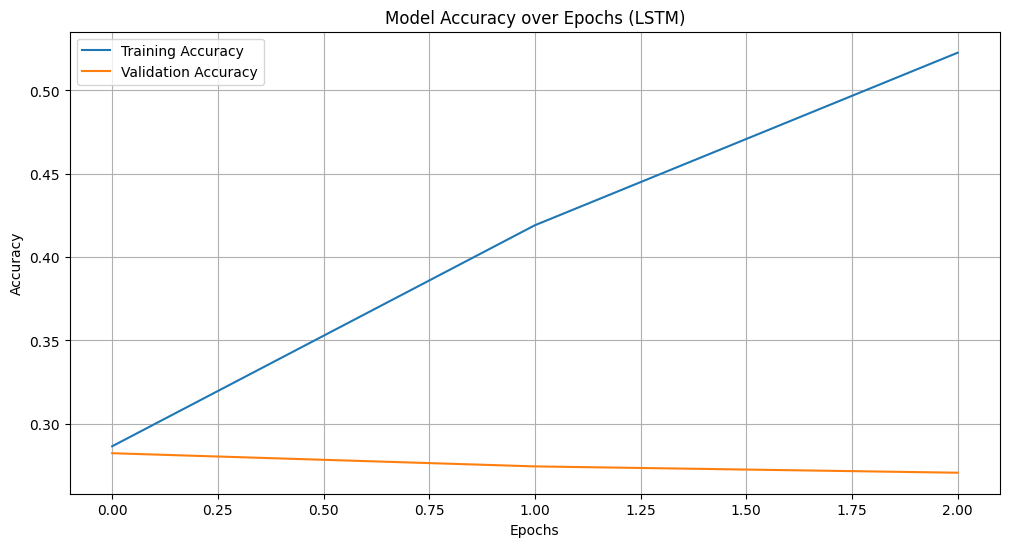

In [97]:
#plot de accuracy en validated accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Model 2: 2 LSTM Layers

In [178]:
# 2. LSTM Model met 2 Lagen
model_2 = keras.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=7,
                            input_length=600),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(7, activation='softmax')
])

model_2.build(input_shape=(None, 600))

model_2.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_37 (Embedding)        │ (None, 600, 7)         │        70,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 600, 32)        │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,671 (326.84 KB)

 Trainable params: 83,671 (326.84 KB)

 Non-trainable params: 0 (0.00 B)

In [179]:
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_2 = model_2.fit(padded_train_10k, subset_training_10k['genre_nr'], epochs=3, validation_data=(padded_val_10k, subset_val_10k['genre_nr']))

Epoch 1/3
108/313 ━━━━━━━━━━━━━━━━━━━━ 6:42:18 118s/step - accuracy: 0.2345 - loss: 1.8506

KeyboardInterrupt: 

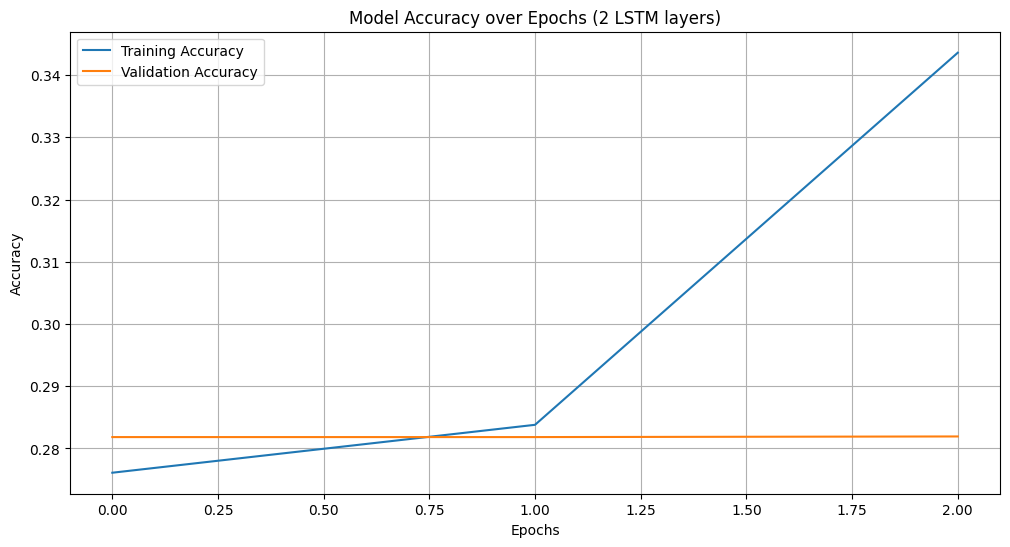

In [100]:
#plot de accuracy en validated accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (2 LSTM layers)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Model 3: GRU Model met Dropout

In [101]:
# 3. GRU Model met Dropout
model_3 = keras.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=7,
                            input_length=600),
    keras.layers.GRU(32, return_sequences=True, dropout=0.2),
    keras.layers.GRU(32),
    keras.layers.Dense(7, activation='softmax')
])

model_3.build(input_shape=(None, 600))

model_3.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 600, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 600, 32)        │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,019,431 (3.89 MB)

 Trainable params: 1,019,431 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_3 = model_3.fit(padded_train_10k, subset_training_10k['genre_nr'], epochs=3, validation_data=(padded_val_10k, subset_val_10k['genre_nr']))

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 208s 645ms/step - accuracy: 0.2480 - loss: 1.8009 - val_accuracy: 0.2682 - val_loss: 1.7569
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 157s 501ms/step - accuracy: 0.3792 - loss: 1.5321 - val_accuracy: 0.3129 - val_loss: 1.7192
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 151s 483ms/step - accuracy: 0.5151 - loss: 1.2640 - val_accuracy: 0.2830 - val_loss: 1.9422


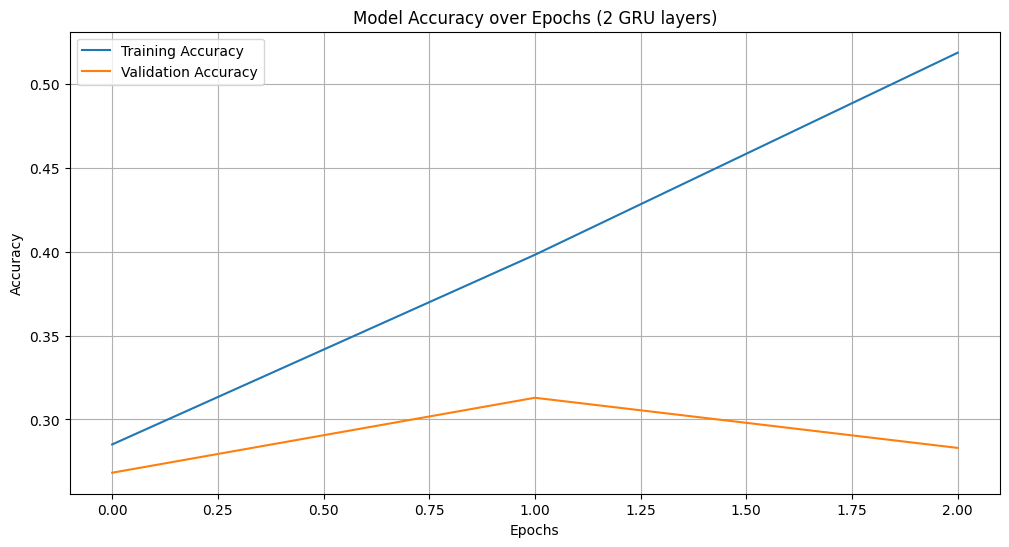

In [103]:
#plot de accuracy en validated accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (2 GRU layers)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Model 4: Bi-directionele GRU Model

In [104]:
# 4. Bi-directionele GRU Model
model_4 = keras.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=7,
                            input_length=600),
    keras.layers.Bidirectional(keras.layers.GRU(32, return_sequences=True, dropout=0.2)),
    keras.layers.Bidirectional(keras.layers.GRU(32, dropout=0.2)),
    keras.layers.Dense(7, activation='softmax')
])

model_4.build(input_shape=(None, 600))

model_4.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 600, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 600, 64)        │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,044,999 (3.99 MB)

 Trainable params: 1,044,999 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_4 = model_4.fit(padded_train_10k, subset_training_10k['genre_nr'], epochs=3, validation_data=(padded_val_10k, subset_val_10k['genre_nr']))

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 215s 663ms/step - accuracy: 0.2768 - loss: 1.7770 - val_accuracy: 0.3089 - val_loss: 1.8525
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 180s 575ms/step - accuracy: 0.3357 - loss: 1.5922 - val_accuracy: 0.3109 - val_loss: 1.7201
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 155s 496ms/step - accuracy: 0.4687 - loss: 1.3290 - val_accuracy: 0.2842 - val_loss: 1.9425


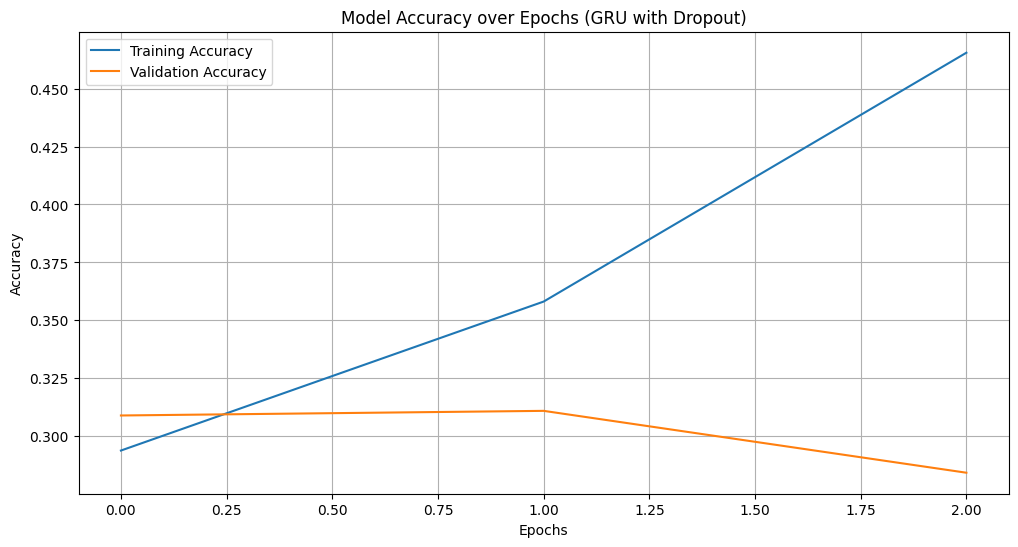

In [106]:
plt.figure(figsize=(12, 6))
plt.plot(history_4.history['accuracy'], label='Training Accuracy')
plt.plot(history_4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (GRU with Dropout)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Model 5: Convolutioneel Model met Conv1D en MaxPooling

In [109]:
# 5. Convolutioneel Model met Conv1D en MaxPooling
model_5 = keras.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=7,
                            input_length=600),
    keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(7, activation='softmax')
])

model_5.build(input_shape=(None, 600))

model_5.summary()

c:\Users\esmee\OneDrive\Documents\Projecten\MachineLearning\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 600, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 598, 32)        │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 299, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 297, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 19008)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 7)              │       133,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,148,903 (4.38 MB)

 Trainable params: 1,148,903 (4.38 MB)

 Non-trainable params: 0 (0.00 B)

In [119]:
model_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_5 = model_5.fit(padded_train_10k, subset_training_10k['genre_nr'], epochs=10, validation_data=(padded_val_10k, subset_val_10k['genre_nr']))

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9704 - loss: 0.1291 - val_accuracy: 0.2578 - val_loss: 3.4288
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9992 - loss: 0.0141 - val_accuracy: 0.2793 - val_loss: 4.0239
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9996 - loss: 0.0032 - val_accuracy: 0.2712 - val_loss: 4.4763
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9994 - loss: 0.0043 - val_accuracy: 0.2677 - val_loss: 4.7131
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.2707 - val_loss: 4.9653
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.2722 - val_loss: 5.1718
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9999 - loss: 5.0423e-04 - val_accuracy: 0.2730 - val_loss: 5.3239
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9999 - loss: 3.3043

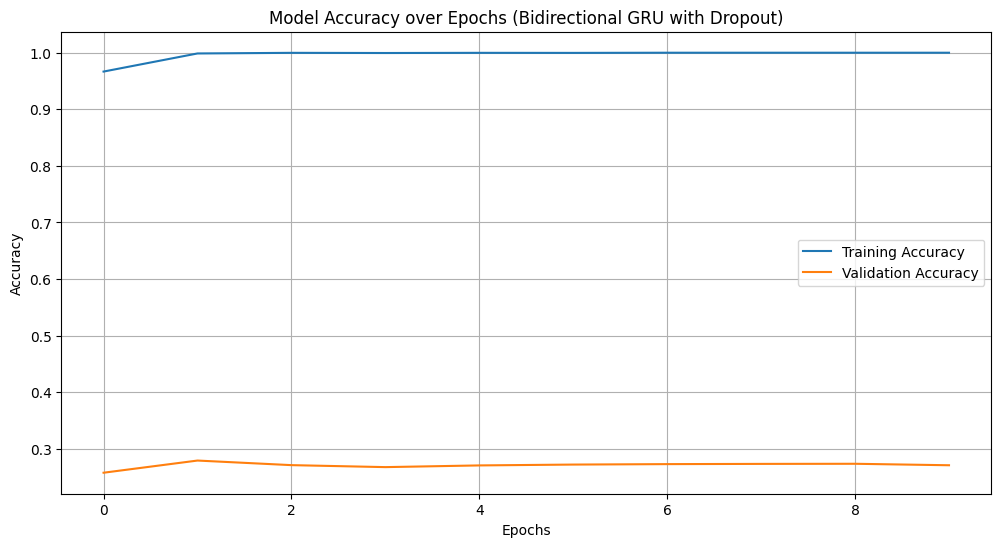

In [127]:
plt.figure(figsize=(12, 6))
plt.plot(history_5.history['accuracy'], label='Training Accuracy')
plt.plot(history_5.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (Bidirectional GRU with Dropout)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Model 6: Verbeterde LSTM met Dropout en Bi-directioneel

In [112]:
# 6. Verbeterde LSTM met Dropout en Bi-directioneel
model_6 = keras.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=7,
                            input_length=600),
    keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True, dropout=0.2)),
    keras.layers.Bidirectional(keras.layers.LSTM(32, dropout=0.2)),
    keras.layers.Dense(7, activation='softmax')
])

model_6.build(input_shape=(None, 600))

model_6.summary()

c:\Users\esmee\OneDrive\Documents\Projecten\MachineLearning\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 600, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 600, 64)        │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,059,335 (4.04 MB)

 Trainable params: 1,059,335 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

In [113]:
model_6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_6 = model_6.fit(padded_train_10k, subset_training_10k['genre_nr'], epochs=3, validation_data=(padded_val_10k, subset_val_10k['genre_nr']))

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 170s 524ms/step - accuracy: 0.2914 - loss: 1.7406 - val_accuracy: 0.3146 - val_loss: 1.6898
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 159s 510ms/step - accuracy: 0.3511 - loss: 1.5312 - val_accuracy: 0.2941 - val_loss: 1.7421
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 180s 577ms/step - accuracy: 0.4335 - loss: 1.3746 - val_accuracy: 0.2919 - val_loss: 1.8918


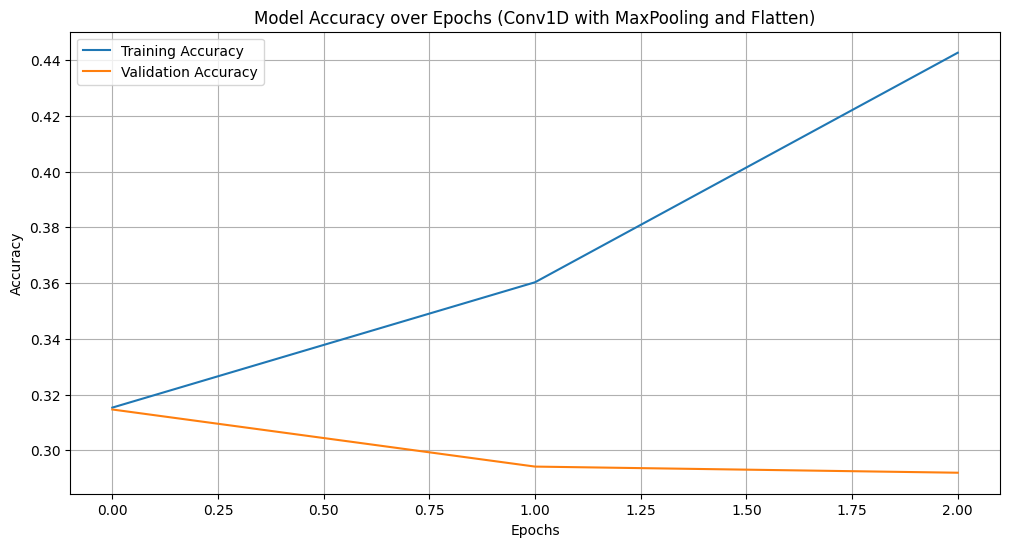

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(history_6.history['accuracy'], label='Training Accuracy')
plt.plot(history_6.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (Conv1D with MaxPooling and Flatten)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Model 7: Verbeterd Convolutioneel Model met Dropout

In [116]:
# 7. Verbeterd Convolutioneel Model met Dropout
model_7 = keras.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=7, input_length=600),
    keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(7, activation='softmax')
])

model_7.build(input_shape=(None, 600))

model_7.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ (None, 600, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 598, 32)        │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 299, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 297, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 148, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 148, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 7)              │        66,311 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,082,151 (4.13 MB)

 Trainable params: 1,082,151 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

In [117]:
model_7.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_7 = model_7.fit(padded_train_10k, subset_training_10k['genre_nr'], epochs=3, validation_data=(padded_val_10k, subset_val_10k['genre_nr']))

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.3093 - loss: 1.6676 - val_accuracy: 0.3110 - val_loss: 1.6658
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5603 - loss: 1.1348 - val_accuracy: 0.2863 - val_loss: 1.8775
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7568 - loss: 0.7002 - val_accuracy: 0.2784 - val_loss: 2.1578


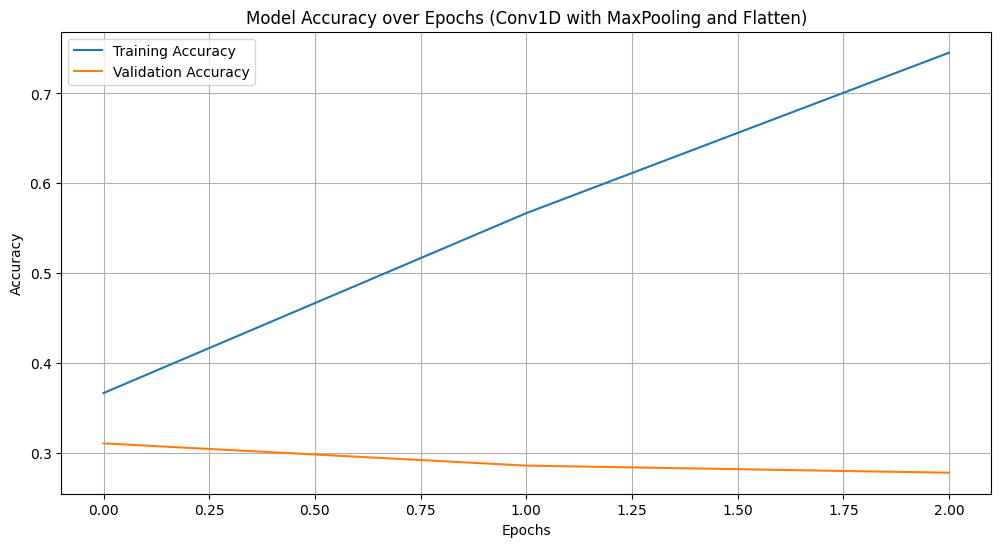

In [118]:
plt.figure(figsize=(12, 6))
plt.plot(history_7.history['accuracy'], label='Training Accuracy')
plt.plot(history_7.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (Conv1D with MaxPooling and Flatten)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Modeling 2 - Categorie Verdeling

Bij de eerste modeling ronde ben ik eerst met een kleine dataset (10k rows) gaan testen welke modellen potentie hadden hieruit kwamen de volgende modellen en waarom:

...

Wat ik nu ga doen is de subset vergroten naar 100k rows voor meer train en test data en ik ga de genre verdeling rechttrekken, er is bijvoorbeeld een overvloed aan `English Literature` maar er is veel minder van `Periodicals`. Daarom ga ik eerst deze prep hieronder doen en hiervoor een aparte subset maken. Daarna train ik deze weer op dezelfde modellen, eerst met 3 epochs soms 10 en als ik potentie zie in het model vergroot ik de subset wellicht meer en verhoog ik de epochs als ik stijging zie.

In [156]:
# Maak subsets aan voor elke dataset met 100k rows
subset_training_100k = create_stratified_subset(df_training, 100000)
subset_val_100k = create_stratified_subset(df_val, 100000)
subset_test_100k = create_stratified_subset(df_test, 100000)

In [157]:
def balance_genres(df, genre_col='main genre'):
    # Bepaal het minimale aantal rijen dat beschikbaar is voor elk genre
    min_count = df[genre_col].value_counts().min()

    # Maak een evenwichtige subset van de data door van elk genre alleen het minimale aantal rijen te nemen
    balanced_df = df.groupby(genre_col).apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

    return balanced_df

# Gebruik de functie om een evenwichtige dataset te maken voor elke subset
subset_training_100k = balance_genres(subset_training_100k)
subset_val_100k = balance_genres(subset_val_100k)
subset_test_100k = balance_genres(subset_test_100k)

# Controleer de nieuwe verdeling
print(subset_training_100k['main genre'].value_counts())
print(subset_val_100k['main genre'].value_counts())
print(subset_test_100k['main genre'].value_counts())

C:\Users\esmee\AppData\Local\Temp\ipykernel_15596\4223858635.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(genre_col).apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)
C:\Users\esmee\AppData\Local\Temp\ipykernel_15596\4223858635.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(genre_col).apply(lambda x: x.sample(min_count,

main genre
American Literature                            3313
English Literature                             3313
Fiction and juvenile belles lettres            3313
History of Europe, Asia, Africa and Oceania    3313
Language and Literature                        3313
Periodicals                                    3313
Philosophy, Psychology and Religion            3313
Name: count, dtype: int64
main genre
American Literature                            3674
English Literature                             3674
Fiction and juvenile belles lettres            3674
History of Europe, Asia, Africa and Oceania    3674
Language and Literature                        3674
Periodicals                                    3674
Philosophy, Psychology and Religion            3674
Name: count, dtype: int64
main genre
American Literature                            3123
English Literature                             3123
Fiction and juvenile belles lettres            3123
History of Europe, Asia, Africa

C:\Users\esmee\AppData\Local\Temp\ipykernel_15596\4223858635.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(genre_col).apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


In [158]:
# Functie om one-hot encoding toe te passen op de main genre kolom
subset_training_100k['genre_nr'] = LabelEncoder().fit_transform(subset_training_100k['main genre'])
subset_test_100k['genre_nr'] = LabelEncoder().fit_transform(subset_test_100k['main genre'])
subset_val_100k['genre_nr'] = LabelEncoder().fit_transform(subset_val_100k['main genre'])

In [159]:
# Tokenize de teksten
train_tokenized_100k = Tokenizer(num_words=100000)
train_tokenized_100k.fit_on_texts(subset_training_100k['txt'])

# Vul de teksten aan tot 600 woorden met padding
sequences_train_100k = train_tokenized_100k.texts_to_sequences(subset_training_100k['txt'])
padded_train_100k = pad_sequences(sequences_train_100k, maxlen=600)

In [160]:
# Tokenize de teksten
val_tokenized_100k = Tokenizer(num_words=100000)
val_tokenized_100k.fit_on_texts(subset_val_100k['txt'])

# Vul de teksten aan tot 600 woorden met padding
sequences_val_100k = val_tokenized_100k.texts_to_sequences(subset_val_100k['txt'])
padded_val_100k = pad_sequences(sequences_val_100k, maxlen=600)

In [161]:
# Tokenize de teksten
test_tokenized_100k = Tokenizer(num_words=100000)
test_tokenized_100k.fit_on_texts(subset_test_100k['txt'])

# Vul de teksten aan tot 600 woorden met padding
sequences_test_100k = test_tokenized_100k.texts_to_sequences(subset_test_100k['txt'])
padded_test_100k = pad_sequences(sequences_test_100k, maxlen=600)

In [167]:
# 5. Convolutioneel Model met Conv1D en MaxPooling
model_5_2 = keras.Sequential([
    keras.layers.Embedding(input_dim=100000, output_dim=7,
                            input_length=600),
    keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(7, activation='softmax')
])

model_5_2.build(input_shape=(None, 600))

model_5_2.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ (None, 600, 7)         │       700,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 598, 32)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 299, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 297, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 19008)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 7)              │       133,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 839,975 (3.20 MB)

 Trainable params: 839,975 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

In [168]:
model_5_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_5_2 = model_5_2.fit(padded_train_100k, subset_training_100k['genre_nr'], epochs=10, validation_data=(padded_val_100k, subset_val_100k['genre_nr']))

Epoch 1/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.3094 - loss: 1.6797 - val_accuracy: 0.2103 - val_loss: 2.0388
Epoch 2/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.6154 - loss: 1.0388 - val_accuracy: 0.1998 - val_loss: 2.2916
Epoch 3/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8106 - loss: 0.5546 - val_accuracy: 0.1836 - val_loss: 3.3830
Epoch 4/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9442 - loss: 0.2033 - val_accuracy: 0.1777 - val_loss: 4.8901
Epoch 5/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.9857 - loss: 0.0579 - val_accuracy: 0.1787 - val_loss: 5.8647
Epoch 6/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9964 - loss: 0.0254 - val_accuracy: 0.1847 - val_loss: 7.2240
Epoch 7/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9983 - loss: 0.0170 - val_accuracy: 0.1752 - val_loss: 8.1059
Epoch 8/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.9958 - loss: 0.0178 - 

In [169]:
# 6. Verbeterde LSTM met Dropout en Bi-directioneel
model_6_2 = keras.Sequential([
    keras.layers.Embedding(input_dim=100000, output_dim=7,
                            input_length=600),
    keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True, dropout=0.2)),
    keras.layers.Bidirectional(keras.layers.LSTM(32, dropout=0.2)),
    keras.layers.Dense(7, activation='softmax')
])

model_6_2.build(input_shape=(None, 600))

model_6_2.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_33 (Embedding)        │ (None, 600, 7)         │       700,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 600, 64)        │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 735,527 (2.81 MB)

 Trainable params: 735,527 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_6_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_6_2 = model_6_2.fit(padded_train_100k, subset_training_100k['genre_nr'], epochs=10, validation_data=(padded_val_100k, subset_val_100k['genre_nr']))

In [148]:
# 7. Verbeterd Convolutioneel Model met Dropout
model_7_2 = keras.Sequential([
    keras.layers.Embedding(input_dim=100000, output_dim=7, input_length=600),
    keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(7, activation='softmax')
])

model_7_2.build(input_shape=(None, 600))

model_7_2.summary()

c:\Users\esmee\OneDrive\Documents\Projecten\MachineLearning\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)        │ (None, 600, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 598, 32)        │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 299, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 297, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 148, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 148, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 9472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 7)              │        66,311 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,082,151 (4.13 MB)

 Trainable params: 1,082,151 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

In [149]:
model_7_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_7_2 = model_7_2.fit(padded_train_100k, subset_training_100k['genre_nr'], epochs=10, validation_data=(padded_val_100k, subset_val_100k['genre_nr']))

Epoch 1/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.3133 - loss: 1.6661 - val_accuracy: 0.2241 - val_loss: 1.9299
Epoch 2/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.5921 - loss: 1.0900 - val_accuracy: 0.2013 - val_loss: 2.2580
Epoch 3/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.7380 - loss: 0.7345 - val_accuracy: 0.1896 - val_loss: 2.6784
Epoch 4/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.8752 - loss: 0.3862 - val_accuracy: 0.1983 - val_loss: 3.3332
Epoch 5/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.9577 - loss: 0.1492 - val_accuracy: 0.1831 - val_loss: 4.4508
Epoch 6/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.9828 - loss: 0.0687 - val_accuracy: 0.1991 - val_loss: 4.9220
Epoch 7/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.9868 - loss: 0.0494 - val_accuracy: 0.1943 - val_loss: 5.6373
Epoch 8/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.9881 - loss: 0.0412 - 

In [171]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Embedding(input_dim=100000, output_dim=7, input_length=600),
    layers.Dropout(.5),
    layers.Flatten(),
    layers.Dropout(.8),
    layers.Dense(7, activation='softmax')
])

model.build(input_shape=(None, 600))

model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)        │ (None, 600, 7)         │       700,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 600, 7)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 4200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 7)              │        29,407 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 729,407 (2.78 MB)

 Trainable params: 729,407 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

In [172]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(padded_train_100k, subset_training_100k['genre_nr'], epochs=10, validation_data = (padded_val_100k, subset_val_100k['genre_nr']))

Epoch 1/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.1885 - loss: 1.9036 - val_accuracy: 0.2955 - val_loss: 1.7552
Epoch 2/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3405 - loss: 1.6289 - val_accuracy: 0.2871 - val_loss: 1.7746
Epoch 3/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4230 - loss: 1.4581 - val_accuracy: 0.2636 - val_loss: 1.8245
Epoch 4/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4776 - loss: 1.3440 - val_accuracy: 0.2349 - val_loss: 1.8348
Epoch 5/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5078 - loss: 1.2768 - val_accuracy: 0.2337 - val_loss: 1.8810
Epoch 6/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5399 - loss: 1.2033 - val_accuracy: 0.2203 - val_loss: 1.9221
Epoch 7/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5566 - loss: 1.1590 - val_accuracy: 0.2282 - val_loss: 1.8962
Epoch 8/10
725/725 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5829 - loss: 1.1050 - val_acc

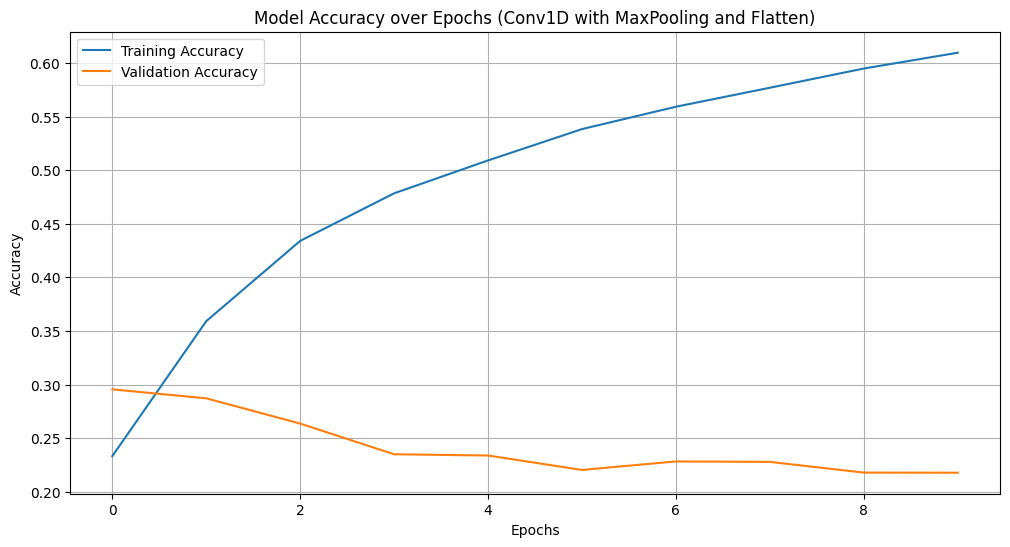

In [173]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs (Conv1D with MaxPooling and Flatten)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation 

[[ go back to the top ]](#Table-of-contents)

Helaas heb ik wegens performance issues en kernel crashes geen modellen kunnen draaien en kan ik dus niks evalueren. Wat ik wel kan doen is een voorspelling maken hoe goed ik denk dat de modellen het gaan doen a.d.v. de resultaten van de werkcolleges.

---

### Model 1: SimpleRNN Layer
Waarschijnlijk de slechtste prestatie vanwege moeite met lange sequenties.

### Model 2: LSTM Layer
Betere prestatie dan SimpleRNN, maar niet het beste.

### Model 3: 2 LSTM Layers
Sterkere prestatie door meer capaciteit voor complexe patronen.

### Model 4: 2 GRU Layers (met Dropout)
Dit model is vergelijkbaar met het model met 2 LSTM-lagen, maar heeft een goed balans tussen prestatie en snelheid.

### Model 5: GRU met Dropout
Vergelijkbaar met Model 4, goed maar mogelijk iets minder efficiënt.

### Model 6: Bidirectional GRU
Eén van de betere modellen, gezien het vermogen om context in beide richtingen te verwerken.

### Model 7: Conv1D met MaxPooling en Flatten
Waarschijnlijk even goed of beter dan bidirectional GRU, vooral vanwege de snelheid en vermogen om lokale patronen efficiënt te herkennen.

# Deployment

[[ go back to the top ]](#Table-of-contents)

Als dit model in de praktijk uitgevoerd zou worden raad ik sterk aan om een batch-verwerkingssysteem op te zetten. Zo kan je redelijk efficiënt data verwerken en dingen tegelijkertijd voorspelleing, in plaats van één voor één. Ook verminderd het de kans op mogelijke crashes vanwege grote hoeveelheden data.

Het is sowieso verstandig om rekening te houden met de grootte van het model en benodigde extra's zoals de datasets. Bij het draaien van de LSTM- en GRU-Netwerken merkte ik al dat mijn laptop én desktop hier veel moeite mee hadden omdat het veel geheugen en rekenkracht vereist. Dit kan voor problemen zorgen in een omgeving met beperkte resources.

---